In [174]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [26]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import os
os.chdir('C:\\Users\\M246047\\Documents\\Python')

In [27]:
# Grab and process the raw data.

amazon = pd.read_csv('amazon_cells_labelled.txt', delimiter= '\t', header=None)
amazon.columns = ['review', 'tone']
amazon.head()
amazon_neg = amazon

In [28]:
amazon['review'] = amazon['review'].str.lower()
amazon.head()

,review,tone
0,so there is no way for me to plug it in here i...,0
1,"good case, excellent value.",1
2,great for the jawbone.,1
3,tied to charger for conversations lasting more...,0
4,the mic is great.,1


## First, we'll create a model based on positive reviews.

keywords = 'great', 'good', 'highly', 'love', 'like', 'nice', 'beautiful', 'brilliant', 'happy', 'excellent', 'perfect', 'would recommend', 'five star', 'well'

In [29]:
keywords = ['great', 'good', 'highly', 'love', 'like', 'nice', 'beautiful', 'brilliant', 'happy', 
            'excellent', 'perfect', 'would recommend', 'five star', 'well', 'quality']

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
#    amazon[str(key)] = amazon.review.str.contains(' ' + str(key) + ' ', case=False)
    amazon[str(key)] = amazon.review.str.contains(str(key), case=False)


In [30]:
# Looking at frequency of words used in positive and negative reviews
positive = amazon.loc[amazon['tone'] == 1]
negative = amazon.loc[amazon['tone'] == 0]

positive_words = pd.Series(np.concatenate([x.split() for x in positive.review])).value_counts()
positive_words = positive_words.drop(['but', 'on', 'it', 'in', 'so', 'are', 'the', 'and', 'i', 'is', 'a', 
                                      'to', 'it', 'this', 'my', 'for', 'with', 'of', 'it', 'was', 'have',
                                     'that', 'has', 'as', 'you', 'than', 'if', 'your', 'at', 'be', 'all', 
                                      'had', 'very', 'phone'])
top_pos = positive_words.iloc[:20]
print('Top positive words: \n', top_pos)

negative_words = pd.Series(np.concatenate([x.split() for x in negative.review])).value_counts()
negative_words = negative_words.drop(['but', 'on', 'it', 'in', 'so', 'are', 'the', 'and', 'i', 'is', 'a', 
                                      'to', 'it', 'this', 'my', 'for', 'with', 'of', 'it', 'was', 'have',
                                    'that', 'has', 'as', 'you', 'than', 'if', 'your', 'at', 'be', 'all', 
                                      'had', 'very', 'phone'])
top_neg = negative_words.iloc[:20]
print('\n Top negative words: \n', top_neg)



Top positive words: 
 great        62
good         53
works        43
headset      24
sound        22
one          22
quality      21
excellent    20
love         20
phone.       20
battery      20
best         19
i've         19
nice         19
like         18
recommend    18
well         17
it's         16
would        16
from         16
dtype: int64

 Top negative words: 
 not        101
don't       23
after       21
battery     19
it.         18
from        17
only        17
would       16
does        16
work        15
then        15
or          15
do          15
when        15
out         15
no          14
use         14
me          14
get         14
doesn't     14
dtype: int64


In [31]:
# keywords = ['not', 'worst', 'horrible', 'poor', 'never', 'waste', 'useless', 'terrible', 'awful', 'bad', 'return',
#            'cheap', 'don\'t', 'beware', 'sucks', 'disappoint', 'displease', 'not recommend', 'junk', 'broke',
#            'no', 'don\'t', 'doesn\'t', 'after', 'battery', 'only', 'when', 'work', 'does', 'use']


amazon['tone'] = (amazon['tone'] == 1) # turns tone into a boolean column
# Note that if you run this cell a second time everything will become false.
# So... Don't.

Our variables are quite independent!

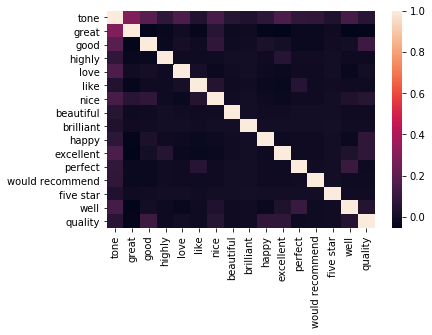

In [32]:
sns.heatmap(amazon.corr())

In [33]:
data = amazon[keywords]
target = amazon['tone']

In [34]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

print('Confusion Matrix:')
print(confusion_matrix(target, y_pred))
print('\n')

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=20)
print('With 30% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

print('With Cross Validation:')
cross_val_score(bnb, data, target, cv=10)

Number of mislabeled points out of a total 1000 points : 264
Confusion Matrix:
[[467  33]
 [231 269]]


With 30% Holdout: 0.72
Testing on Sample: 0.736
With Cross Validation:


array([0.84, 0.74, 0.78, 0.72, 0.74, 0.71, 0.68, 0.66, 0.76, 0.67])

While our holdout test was quite close, the cross validation, with a range of 15%-20%, indicates our model could use some work in that there is overfitting. The Confusion Matrix tells us that the we're marking positive reviews correctly for the most part and that our main problem is with the false positives - we're incorrectly marking many negative reviews as positive. 

## All Positive Terms

I'm now going to create a model with the positive terms I chose above in addition to the terms that show up in my top positive terms after I've removed generic terms like 'I' and 'the'. This will include words like 'phone' and 'headset', so I imagine this model will be less accurae in addition to having more overfitting.

In [14]:
amazon = pd.read_csv('amazon_cells_labelled.txt', delimiter= '\t', header=None)
amazon.columns = ['review', 'tone']
amazon.head()
amazon_neg = amazon

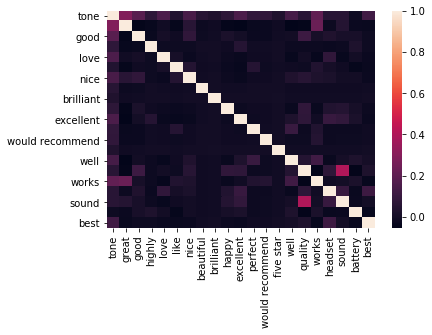

In [15]:
keywords = ['great', 'good', 'highly', 'love', 'like', 'nice', 'beautiful', 'brilliant', 'happy', 
            'excellent', 'perfect', 'would recommend', 'five star', 'well', 'quality',
            'works', 'headset', 'sound', 'battery', 'best']

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
#    amazon[str(key)] = amazon.review.str.contains(' ' + str(key) + ' ', case=False)
    amazon[str(key)] = amazon.review.str.contains(str(key), case=False)
amazon.head()

amazon['tone'] = (amazon['tone'] == 1) # turns tone into a boolean column

sns.heatmap(amazon.corr())

In [16]:
data = amazon[keywords]
target = amazon['tone']

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

print('Confusion Matrix:')
print(confusion_matrix(target, y_pred))
print('\n')

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=20)
print('With 30% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

print('With Cross Validation:')
cross_val_score(bnb, data, target, cv=10)

Number of mislabeled points out of a total 1000 points : 239
Confusion Matrix:
[[456  44]
 [195 305]]


With 30% Holdout: 0.7566666666666667
Testing on Sample: 0.761
With Cross Validation:


array([0.84, 0.76, 0.83, 0.73, 0.79, 0.72, 0.7 , 0.72, 0.81, 0.69])

Similarly to our first model, the holdout test is very close but the cross validation has quite a large range which indicates this model could be improved. This model correctly labeled more negative reviews than the original, but the Confusion Matrix tells us that we still have a problem catching the false positives - we're incorrectly marking many negative reviews as positive. 

## Now we'll create a model based on negative reviews.

keywords = 'not', 'worst', 'horrible', 'poor', 'never', 'waste', 'useless', 'terrible', 'awful', 'bad', 'return', 'cheap', 'don't', 'beware', 'sucks', 'disappoint', 'displease', 'not recommend', 'junk', 'broke', 'no', 'doesn't'

In [17]:
amazon = pd.read_csv('amazon_cells_labelled.txt', delimiter= '\t', header=None)
amazon.columns = ['review', 'tone']

keywords = ['not', 'worst', 'horrible', 'poor', 'never', 'waste', 'useless', 'terrible', 'awful', 'bad', 'return',
           'cheap', 'don\'t', 'beware', 'sucks', 'disappoint', 'displease', 'not recommend', 'junk', 'broke',
           'no', 'don\'t', 'doesn\'t']


for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
#    amazon[str(key)] = amazon.review.str.contains(' ' + str(key) + ' ', case=False)
    amazon[str(key)] = amazon.review.str.contains(str(key), case=False)

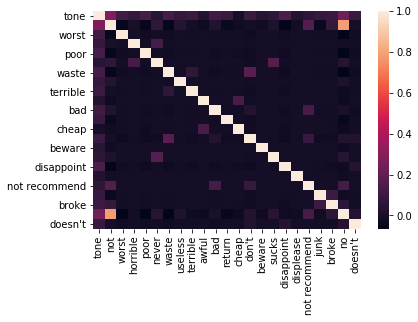

In [18]:
amazon['tone'] = (amazon['tone'] == 0) # turns tone into a boolean column
# Note that if you run this cell a second time everything will become false.
# So... Don't.
sns.heatmap(amazon.corr())

data = amazon[keywords]
target = amazon['tone']

Our variables/features appear to be quite independent from one another.

In [19]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

print('Confusion Matrix:')
print(confusion_matrix(target, y_pred))

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=20)
print('With 30% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

print('With Cross Validation:')
cross_val_score(bnb, data, target, cv=10)

Number of mislabeled points out of a total 1000 points : 268
Confusion Matrix:
[[446  54]
 [214 286]]
With 30% Holdout: 0.7233333333333334
Testing on Sample: 0.732
With Cross Validation:


array([0.69, 0.76, 0.78, 0.68, 0.81, 0.66, 0.68, 0.73, 0.77, 0.71])

While this model mislabeled more reviews than our first two, the Cross Validation is the best we've seen so far, indicating that it's the most precise, if not the most accurate, model.  --> Is this a true statement?

However, overfitting is still present. 

I created two models, one for positive reviews and one for negative, for this data. I created both models using keywords that were present in the reviews - I'd love to add features other than keywords, but was not able to think of any. 

## All Negative Terms

I'm now going to create a model with the negative terms I chose above in addition to the terms that show up in my top positive terms after I've removed generic terms like 'I' and 'the'. This will include words like 'only' and 'battery', so I imagine this model will be less accurae in addition to having more overfitting.

In [20]:
amazon = pd.read_csv('amazon_cells_labelled.txt', delimiter= '\t', header=None)
amazon.columns = ['review', 'tone']

keywords = ['not', 'worst', 'horrible', 'poor', 'never', 'waste', 'useless', 'terrible', 'awful', 'bad', 'return',
           'cheap', 'don\'t', 'beware', 'sucks', 'disappoint', 'displease', 'not recommend', 'junk', 'broke',
           'no', 'don\'t', 'doesn\'t', 'after', 'battery', 'only', 'when', 'work', 'does', 'use']


for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
#    amazon[str(key)] = amazon.review.str.contains(' ' + str(key) + ' ', case=False)
    amazon[str(key)] = amazon.review.str.contains(str(key), case=False)

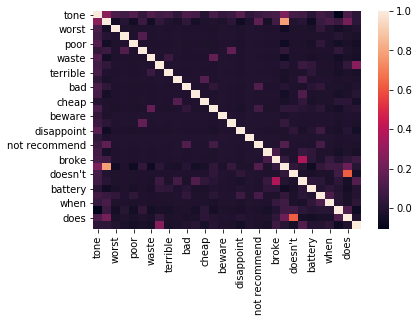

In [21]:
amazon['tone'] = (amazon['tone'] == 0) # turns tone into a boolean column
# Note that if you run this cell a second time everything will become false.
# So... Don't.
sns.heatmap(amazon.corr())

data = amazon[keywords]
target = amazon['tone']

In [22]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

print('Confusion Matrix:')
print(confusion_matrix(target, y_pred))

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=20)
print('With 30% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

print('With Cross Validation:')
cross_val_score(bnb, data, target, cv=10)

Number of mislabeled points out of a total 1000 points : 254
Confusion Matrix:
[[445  55]
 [199 301]]
With 30% Holdout: 0.73
Testing on Sample: 0.746
With Cross Validation:


array([0.71, 0.78, 0.8 , 0.72, 0.81, 0.66, 0.67, 0.76, 0.74, 0.73])

Adding the extra terms/features did not make much of a difference at all. Ideally, I'd combine the positive and negative into one model. I'm going to try that next.

## Note to Self: Looking at Positive and Negative Terms

I'd like to create a model that marks positive terms as True and negative terms as False. Come back and try to figure this out!

In [25]:
amazon = pd.read_csv('amazon_cells_labelled.txt', delimiter= '\t', header=None)
amazon.columns = ['review', 'tone']

pos_keywords = ['great', 'good', 'highly', 'love', 'like', 'nice', 'beautiful', 'brilliant', 'happy', 
            'excellent', 'perfect', 'would recommend', 'five star', 'well', 'quality']

neg_keywords = ['not', 'worst', 'horrible', 'poor', 'never', 'waste', 'useless', 'terrible', 'awful', 'bad', 'return',
           'cheap', 'beware', 'sucks', 'disappoint', 'displease', 'not recommend', 'junk', 'broke', 'no']
# 'don\'t', 'doesn\'t'

for key in pos_keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
#    amazon[str(key)] = amazon.review.str.contains(' ' + str(key) + ' ', case=False)
    amazon[str(key)] = amazon.review.str.contains(str(key), case=False)
    
for key in neg_keywords:
    amazon['not ' + str(key)] = ~amazon.review.str.contains(str(key), case=False)
    
amazon.head(20)
amazon[neg_keywords]

KeyError: "None of [Index(['not', 'worst', 'horrible', 'poor', 'never', 'waste', 'useless',\n       'terrible', 'awful', 'bad', 'return', 'cheap', 'beware', 'sucks',\n       'disappoint', 'displease', 'not recommend', 'junk', 'broke', 'no'],\n      dtype='object')] are in the [columns]"

In [141]:
amazon['tone'] = (amazon['tone'] == 1) # turns tone into a boolean column
# Note that if you run this cell a second time everything will become false.
# So... Don't.
sns.heatmap(amazon.corr())

data = pd.concat([amazon[pos_keywords], amazon[neg_keywords], axis=1, sort=False)
target = amazon['tone']

SyntaxError: invalid syntax (<ipython-input-141-9f0803b72298>, line 6)

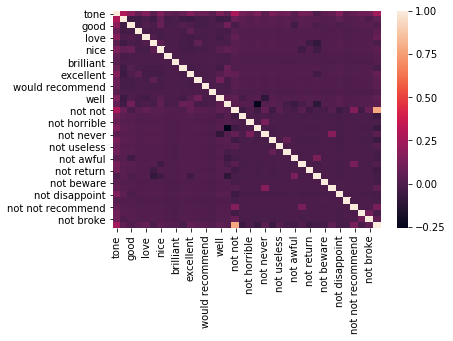

In [147]:
amazon['tone'] = (amazon['tone'] == 1) # turns tone into a boolean column
# Note that if you run this cell a second time everything will become false.
# So... Don't.
sns.heatmap(amazon.corr())